In [1]:
import pandas as pd
import re
import codecs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.cluster import KMeans
import folium
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
%matplotlib inline

## Parse file and write it in out.csv

In [ ]:
f = codecs.open('get_data.txt', 'r', 'utf-8')
file = str(f.read())
#url
r0 = re.compile('\s+<(https://www.immobilienscout24.de/expose/.*)>\r\n\s+\d?/?\d{0,2}?\r?\n?\s{0,4}?/?/?\r?\n?\s{0,4}\n?\s{0,4}?\d+\.\d+\skm\s\|\r\n\s+.*\r')
url = r0.findall(file)
#adress
r1 = re.compile('\s+<https://www.immobilienscout24.de/expose/.*>\r\n\s+\d?/?\d{0,2}?\r?\n?\s{0,4}?/?/?\r?\n?\s{0,4}\n?\s{0,4}?\d+\.\d+\skm\s\|\r\n\s+(.*)\r')
adress = r1.findall(file)
#rent
r2 = re.compile('\s+<https://www.immobilienscout24.de/expose/.*>\r\n\s+\d?/?\d{0,2}?\r?\n?\s{0,4}?/?/?\r?\n?\s{0,4}\n?\s{0,4}?\d+\.\d+\skm\s\|\r\n\s+.*\r\n\s+(\d+\.?\d{0,3},?\d{0,2})')
rent = r2.findall(file)
#space
r3 = re.compile('\s+<https://www.immobilienscout24.de/expose/.*>\r\n\s+\d?/?\d{0,2}?\r?\n?\s{0,4}?/?/?\r?\n?\s{0,4}\n?\s{0,4}?\d+\.\d+\skm\s\|\r\n\s+.*\r\n\s+\d+\.?\d{0,3},?\d{0,2}.*\n.*\n\r\n\s+(\d+,?\d*)')
space = r3.findall(file)
#rooms
r4 = re.compile('\s+<https://www.immobilienscout24.de/expose/.*>\r\n\s+\d?/?\d{0,2}?\r?\n?\s{0,4}?/?/?\r?\n?\s{0,4}\n?\s{0,4}?\d+\.\d+\skm\s\|\r\n\s+.*\r\n\s+\d+\.?\d{0,3},?\d{0,2}.*\n.*\n\r\n\s+\d+,?\d*.*\n.*\n.*\n\s+(\d).*\n.*\n.*\n.*')
rooms = r4.findall(file)
#informations
r5 = re.compile('\s+<https://www.immobilienscout24.de/expose/.*>\r\n\s+\d?/?\d{0,2}?\r?\n?\s{0,4}?/?/?\r?\n?\s{0,4}\n?\s{0,4}?\d+\.\d+\skm\s\|\r\n\s+.*\r\n\s+\d+\.?\d{0,3},?\d{0,2}.*\n.*\n\r\n\s+\d+,?\d*.*\n.*\n.*\n\s+\d.*\n.*\n.*\n.*\n.*\n.*\n')
r6 = re.compile('.*\n.*\n.*\n\s+o\s(.*)\r\n\s+o\s(.*)\r\n\s+o\s(.*)\r\n\s{0,4}?o?\s?(.*)?')
informations = []
for element in r5.findall(file):
    if len(r6.findall(element))==0:
        informations.append('')
    else:
        info = ''
        for i in range(len(r6.findall(element)[0])):
            if r6.findall(element)[0][i]!='...' and r6.findall(element)[0][i]!='':
                info += r6.findall(element)[0][i] +' '
        informations.append(info)
      
output = open('out.csv','a')

for i in range(len(url)):
    output.write(rent[i]+';'+space[i]+';'+rooms[i]+';'+adress[i]+';'+informations[i]+';'+url[i]+'\n')
output.close()

dataframe = pd.read_csv('out.csv',engine='python',sep=';')
dataframe.shape

## Pre Processing

In [2]:
df = pd.read_csv('out.csv',engine='python',sep=';',thousands='.',decimal=',')
#drop rows that occur more than once and reset index
df.drop(df[df.duplicated()].index,inplace=True)
df.reset_index(drop=True,inplace = True)
#convert data types
df = df.astype({'Rooms':'float64'})

#create a boroughs dictionary
boroughs_berlin = pd.read_html('https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins')[1]
b_dict = {'Mitte':[],'Friedrichshain-Kreuzberg':[],'Pankow':[],'Charlottenburg-Wilmersdorf':[],'Spandau':[],'Steglitz-Zehlendorf':[],'Tempelhof-Schöneberg':[],'Neukölln':[],'Treptow-Köpenick':[],'Marzahn-Hellersdorf':[],'Lichtenberg':[],'Reinickendorf':[]}
for borough in pd.unique(boroughs_berlin['Bezirk']):
    b_dict[borough].extend(list(boroughs_berlin[boroughs_berlin['Bezirk']==borough]['Ortsteil']))
    
df.insert(4, "Borough", ['' for i in range(df.shape[0])], True)
for i in range(df.shape[0]):
    test_adress = re.findall('(.*), Berlin',df['Adress'][i])
    #Berlin 
    if len(test_adress)>0:
        #if there is no adress 
        if len(re.findall(',',test_adress[0]))==0:
            df.at[i,'Adress'] = test_adress[0]
            for key, value in b_dict.items():
                #if there is only the borough without additional characters
                if test_adress[0] in value:
                    df.at[i,'Borough'] = key
                
            #if there is the borough with additional characters    
            if len(re.findall('(.*) \(',test_adress[0]))>0:
                for key, value in b_dict.items():
                    if re.findall('(.*) \(',test_adress[0])[0] in value:
                        df.at[i,'Borough'] = key

           
        else:
            df.at[i,'Adress'] = re.findall('(.*),.*',test_adress[0])[0]
            #for example Prenzlauer Berg
            if len(re.findall('.*, (\w+ \w+)',test_adress[0]))>0:
                for key, value in b_dict.items():
                    if re.findall('.*, (\w+ \w+)',test_adress[0])[0] in value:
                        df.at[i,'Borough'] = key
                        
            
            
            for key, value in b_dict.items():
                # for example adress, Mitte (Ortsteil)
                if len(re.findall('.*, (.*) ',test_adress[0]))>0:
                    if re.findall('.*, (.*) ',test_adress[0])[0] in value:
                        df.at[i,'Borough'] = key
                    else:
                        if len(re.findall('.*, (.*)',test_adress[0])[0])>0 and re.findall('.*, (.*)',test_adress[0])[0] in value:
                            df.at[i,'Borough'] = key
                    
                else:
                    if re.findall('.*, (.*)',test_adress[0])[0] in value:
                        df.at[i,'Borough'] = key
                    
            
                        
    #Brandenburg and Berlin with no ', Berlin'
    else:
        test_adress = re.findall('(.*),',df['Adress'][i])
        if len(re.findall(',',test_adress[0]))==0:
            df.at[i,'Adress'] = 'Brandenburg'
            df.at[i,'Borough'] = 'Brandenburg'
        else:
            if len(re.findall('\d+',df['Adress'][i]))>0:
                df.at[i,'Adress'] = re.findall('(.*\d+)',df['Adress'][i])[0]
                df.at[i,'Borough'] = 'Brandenburg'
            else:
                df.at[i,'Adress'] = 'Brandenburg'
                df.at[i,'Borough'] = 'Brandenburg'
        


df.drop(df[df['Borough']==''].index,inplace=True)
df.reset_index(drop=True,inplace = True)
#df['Borough'].unique()
print(df.shape)
df.head()


(2557, 7)


,Rent,Space,Rooms,Adress,Borough,Informations,URL
0,954.0,52.88,2.0,Singerstraße 33,Friedrichshain-Kreuzberg,Balkon/Terrasse Einbauküche,https://www.immobilienscout24.de/expose/125663543
1,4830.0,210.00,4.0,Mitte (Ortsteil),Mitte,Online-Besichtigung Balkon/Terrasse,https://www.immobilienscout24.de/expose/123286462
2,1494.0,71.16,2.0,Voltairestraße 11,Mitte,Balkon/Terrasse Einbauküche,https://www.immobilienscout24.de/expose/125310490
3,2080.0,101.36,3.0,Voltairestraße 11,Mitte,Balkon/Terrasse Einbauküche,https://www.immobilienscout24.de/expose/123681050
4,1399.0,67.03,2.0,Voltairestraße 11,Mitte,Balkon/Terrasse Einbauküche,https://www.immobilienscout24.de/expose/123681040


### Get coordinates of apartements

In [29]:
from geopy.geocoders import Nominatim
import progressbar

In [17]:
locator = Nominatim(user_agent="myGeocoder")
long = []
lat = []
bar = progressbar.ProgressBar(maxval=df.shape[0], \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start
for i in range(df.shape[0]):
    location = locator.geocode(df['Adress'][i]+', '+df['Borough'][i]+ ', Deutschland')
    if location == None:
        lat.append(np.NaN)
        long.append(np.NaN)
    else:
        #print(location)
        lat.append(location[1][0])
        long.append(location[1][1])

    bar.update(i+1)

[======================================================================= ]  98%

In [18]:
df.insert(4, "lat", lat, True)
df.insert(5, "long", long, True)

### If I don't have coordinates, take the coordinates of the boroughs

Charlottenburg-Wilmersdorf


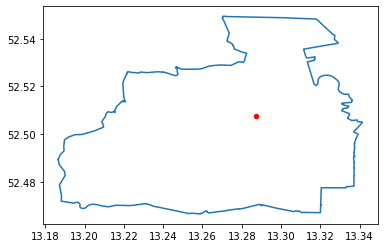

Friedrichshain-Kreuzberg


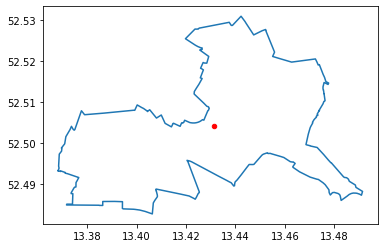

Lichtenberg


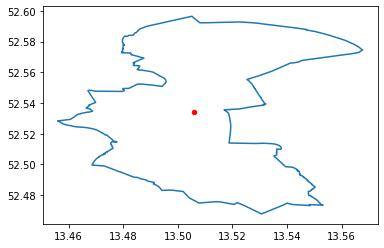

Marzahn-Hellersdorf


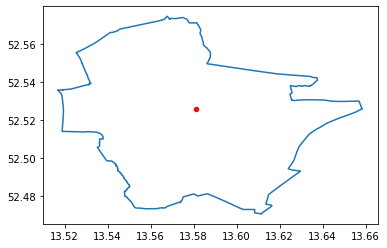

Mitte


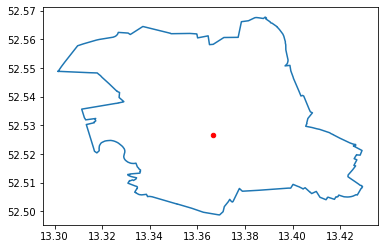

Neukölln


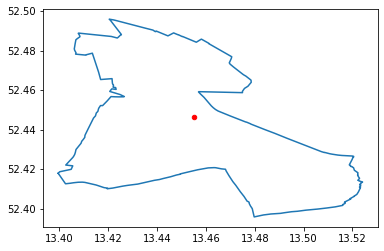

Pankow


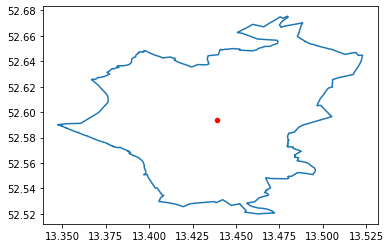

Reinickendorf


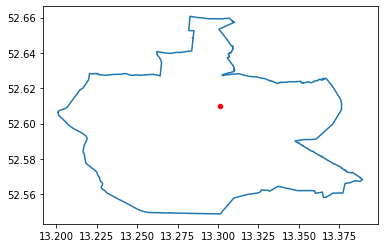

Spandau


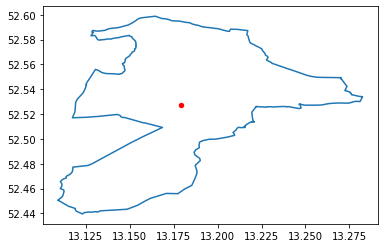

Steglitz-Zehlendorf


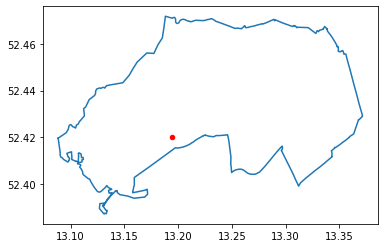

Tempelhof-Schöneberg


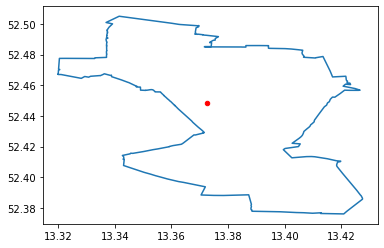

Treptow-Köpenick


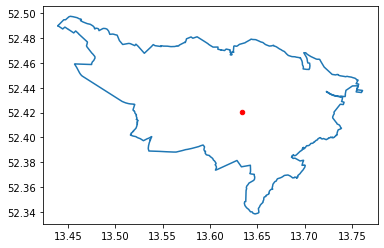

In [32]:
berlin = pd.read_json('Berlin.json', lines=True)
for i in range(12):
    x=[]
    y=[]
    for element in berlin['geometry'][i]['coordinates'][0][0]:   
        x.append(element[0])
        y.append(element[1])
        
    X=berlin['geometry'][i]['coordinates'][0][0]
    k_means = KMeans(init = "k-means++", n_clusters = 1, n_init = 12)
    k_means.fit(X)
    k_means_cluster_centers = k_means.cluster_centers_
    
    for index in df.loc[(df['lat'].isna())&(df['Borough']==berlin['properties'][i]['name'])].index:
        df.at[index,'long'] = k_means_cluster_centers[0][0]
        df.at[index,'lat'] = k_means_cluster_centers[0][1]
    
    print(berlin['properties'][i]['name'])
    plt.plot(x,y)
    plt.scatter(k_means_cluster_centers[0][0],k_means_cluster_centers[0][1],marker='o',color='r',s=20)
    plt.show()

In [43]:
df.drop(df[df['lat'].isna()].index,inplace=True)

In [72]:
#€/m^2
eur_sqm = df['Rent']/df['Space']
df.insert(1, "eur_sqm", eur_sqm, True)
#drop this row because the space is wrong (it is zero)
df.drop(df[df['eur_sqm']==np.inf].index,inplace=True)

In [2]:
df.to_csv('preprocessed.csv')

In [2]:
df = pd.read_csv('preprocessed.csv')
df.drop('Unnamed: 0',axis =1,inplace=True)

## Analysis

In [3]:
df.groupby('Borough').size()
df.groupby('Borough')['Rent'].mean().sort_values()

Borough
Marzahn-Hellersdorf            592.665362
Lichtenberg                    685.973101
Brandenburg                    818.685312
Spandau                        897.131410
Neukölln                       908.724714
Treptow-Köpenick               948.043803
Reinickendorf                  976.571702
Pankow                        1254.820397
Tempelhof-Schöneberg          1341.678077
Steglitz-Zehlendorf           1396.871500
Friedrichshain-Kreuzberg      1411.549820
Mitte                         1629.956071
Charlottenburg-Wilmersdorf    1734.454848
Name: Rent, dtype: float64

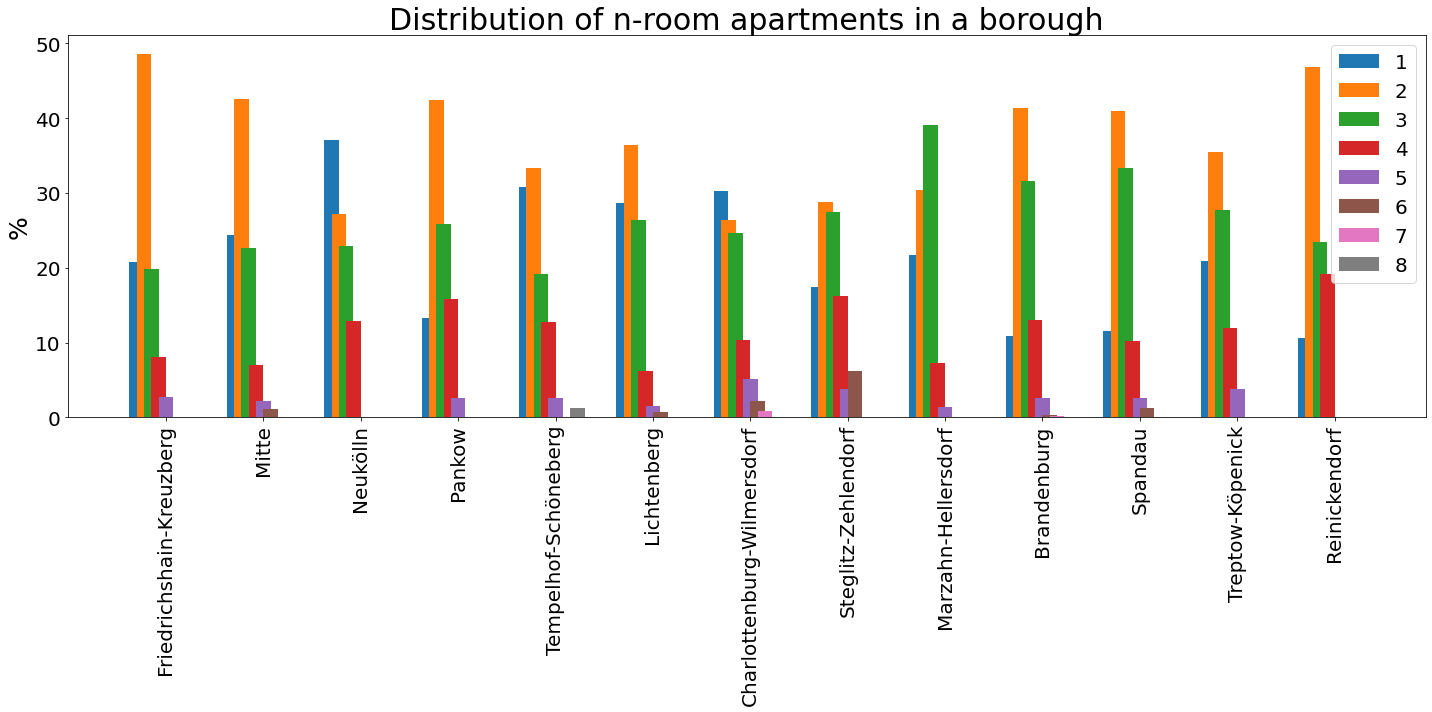

In [27]:
#prepare for plot
#calculate the percentage of n-room apartments in a borough
r = [[],[],[],[],[],[],[],[]]
for bor in df['Borough'].unique():
    for i, r_numb in enumerate(df.groupby(['Borough','Rooms']).size()[bor].index):
        r[int(r_numb)-1].append(100*df.groupby(['Borough','Rooms']).size()[bor].values[i]/df.groupby(['Borough','Rooms']).size()[bor].sum())
    for i in range(8):
        if float(i+1) not in df.groupby(['Borough','Rooms']).size()[bor].index:
            r[i].append(0)
            
x = np.arange(13)
width = 0.15
fig, ax = plt.subplots(figsize=(20,10),tight_layout=True)
rects1 = ax.bar(x - 2*width, r[0], width, label='1')
rects2 = ax.bar(x - 3*width/2, r[1], width, label='2')
rects3 = ax.bar(x - width, r[2], width, label='3')
rects4 = ax.bar(x - width/2, r[3], width, label='4')
rects5 = ax.bar(x , r[4], width, label='5')
rects6 = ax.bar(x + width/2, r[5], width, label='6')
rects7 = ax.bar(x + width, r[6], width, label='7')
rects8 = ax.bar(x + 3*width/2, r[7], width, label='8')

ax.set_ylabel('%',fontsize=25)
ax.set_title('Distribution of n-room apartments in a borough',fontsize=30)
ax.set_xticks(x)
ax.set_xticklabels(df['Borough'].unique(),rotation=90)
ax.tick_params(axis='both',which='major',labelsize=20)
ax.legend(fontsize=20)
fig.savefig('dist_n_rooms.png')

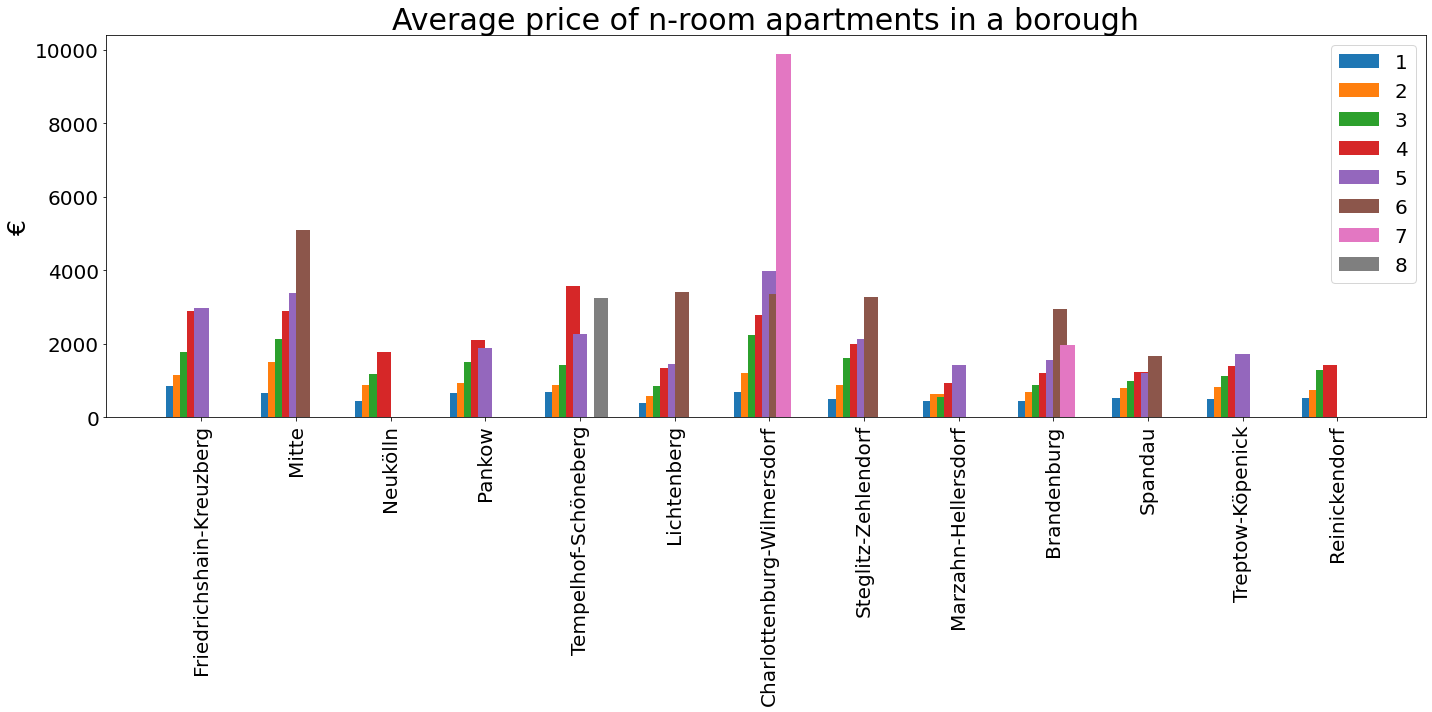

In [29]:
#prepare for plot
r = [[],[],[],[],[],[],[],[]]
for bor in df['Borough'].unique():
    for i, r_numb in enumerate(df.groupby(['Borough','Rooms']).size()[bor].index):
        r[int(r_numb)-1].append(df.groupby(['Borough','Rooms'])['Rent'].mean()[bor].values[i])
    for i in range(8):
        if float(i+1) not in df.groupby(['Borough','Rooms']).size()[bor].index:
            r[i].append(0)
            
x = np.arange(13)
width = 0.15
fig, ax = plt.subplots(figsize=(20,10),tight_layout=True)
rects1 = ax.bar(x - 2*width, r[0], width, label='1')
rects2 = ax.bar(x - 3*width/2, r[1], width, label='2')
rects3 = ax.bar(x - width, r[2], width, label='3')
rects4 = ax.bar(x - width/2, r[3], width, label='4')
rects5 = ax.bar(x , r[4], width, label='5')
rects6 = ax.bar(x + width/2, r[5], width, label='6')
rects7 = ax.bar(x + width, r[6], width, label='7')
rects8 = ax.bar(x + 3*width/2, r[7], width, label='8')

ax.set_ylabel('\u20ac',fontsize=25)
ax.set_title('Average price of n-room apartments in a borough',fontsize=30)
ax.set_xticks(x)
ax.set_xticklabels(df['Borough'].unique(),rotation=90)
ax.tick_params(axis='both',which='major',labelsize=20)
ax.legend(fontsize=20)

fig.savefig('avg_price.png')

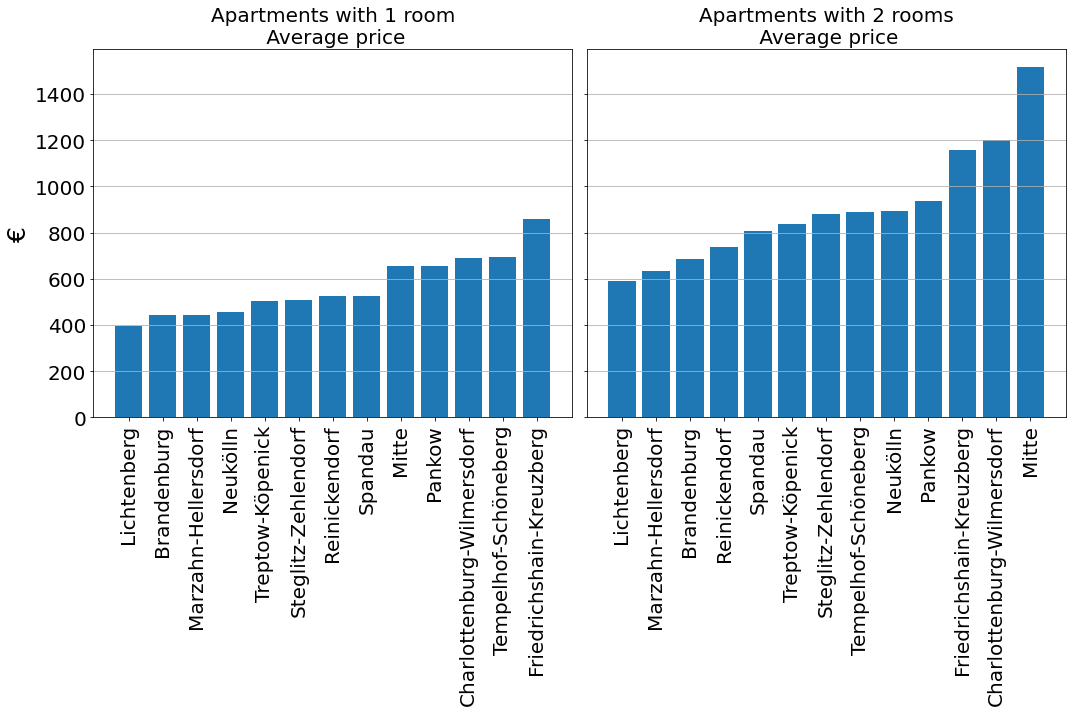

In [20]:
fig, axs = plt.subplots(1,2,figsize=(15,10),sharey=True,tight_layout=True)
#1 room
x=df[df['Rooms']==1].groupby('Borough')['Rent'].mean().sort_values().index
y=df[df['Rooms']==1].groupby('Borough')['Rent'].mean().sort_values().values
axs[0].bar(x,y)

axs[0].set_ylabel('\u20ac',fontsize=25)
axs[0].set_title('Apartments with 1 room\n Average price',fontsize=20)
axs[0].set_xticks(np.arange(13))
axs[0].set_xticklabels(x,rotation=90)
axs[0].tick_params(axis='both',which='major',labelsize=20)
#2 rooms
x=df[df['Rooms']==2].groupby('Borough')['Rent'].mean().sort_values().index
y=df[df['Rooms']==2].groupby('Borough')['Rent'].mean().sort_values().values
axs[1].bar(x,y)

#axs[1].set_ylabel('\u20ac',fontsize=25)
axs[1].set_title('Apartments with 2 rooms\n Average price',fontsize=20)
axs[1].set_xticks(np.arange(13))
axs[1].set_xticklabels(x,rotation=90)
axs[1].tick_params(axis='both',which='major',labelsize=20)

axs[0].grid(axis='y')
axs[1].grid(axis='y')

fig.savefig('avg_apart_1_2.png')

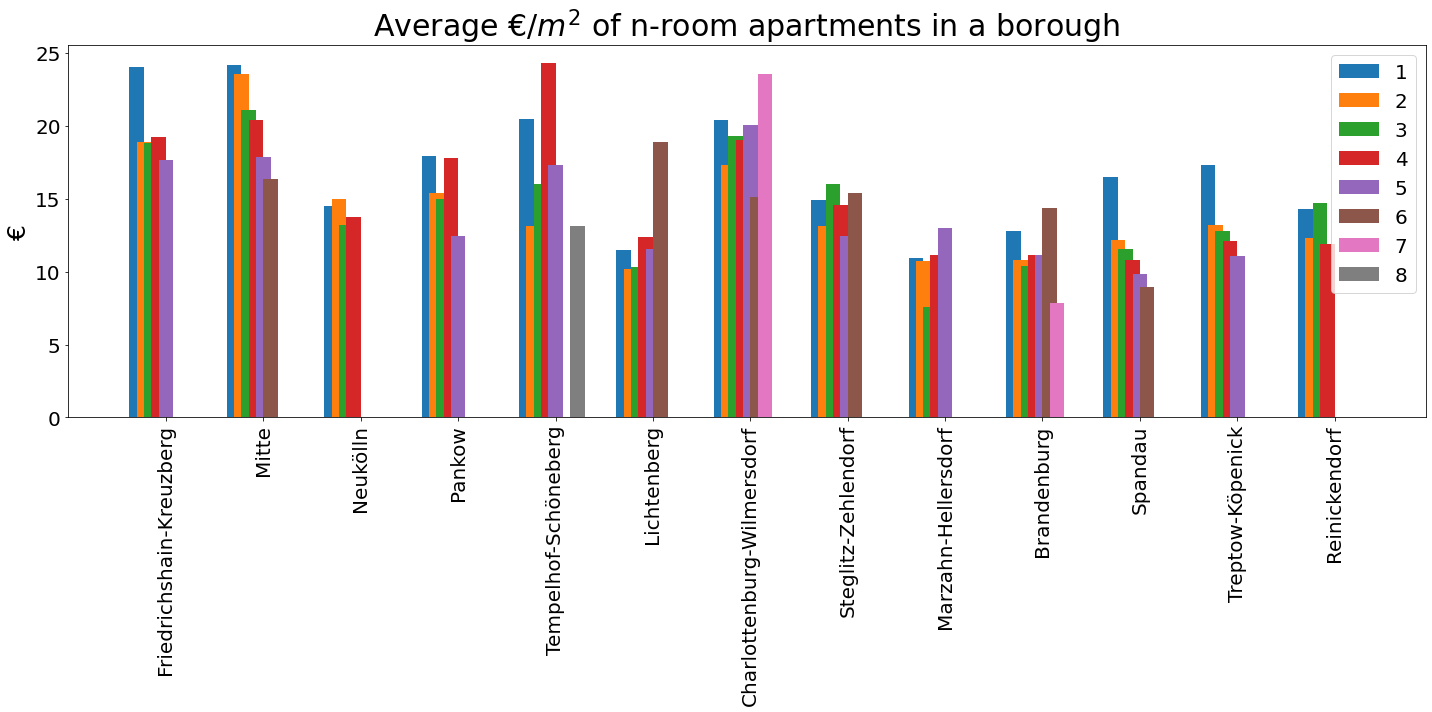

In [31]:
#euro / m^2
#prepare for plot
r = [[],[],[],[],[],[],[],[]]
for bor in df['Borough'].unique():
    for i, r_numb in enumerate(df.groupby(['Borough','Rooms']).size()[bor].index):
        r[int(r_numb)-1].append(df.groupby(['Borough','Rooms'])['eur_sqm'].mean()[bor].values[i])
    for i in range(8):
        if float(i+1) not in df.groupby(['Borough','Rooms']).size()[bor].index:
            r[i].append(0)
            
x = np.arange(13)
width = 0.15
fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - 2*width, r[0], width, label='1')
rects2 = ax.bar(x - 3*width/2, r[1], width, label='2')
rects3 = ax.bar(x - width, r[2], width, label='3')
rects4 = ax.bar(x - width/2, r[3], width, label='4')
rects5 = ax.bar(x , r[4], width, label='5')
rects6 = ax.bar(x + width/2, r[5], width, label='6')
rects7 = ax.bar(x + width, r[6], width, label='7')
rects8 = ax.bar(x + 3*width/2, r[7], width, label='8')

ax.set_ylabel('\u20ac',fontsize=25)
ax.set_title(r'Average €/$m^2$ of n-room apartments in a borough',fontsize=30)
ax.set_xticks(x)
ax.set_xticklabels(df['Borough'].unique(),rotation=90)
ax.tick_params(axis='both',which='major',labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()
fig.savefig('avg_price_sqm.png')

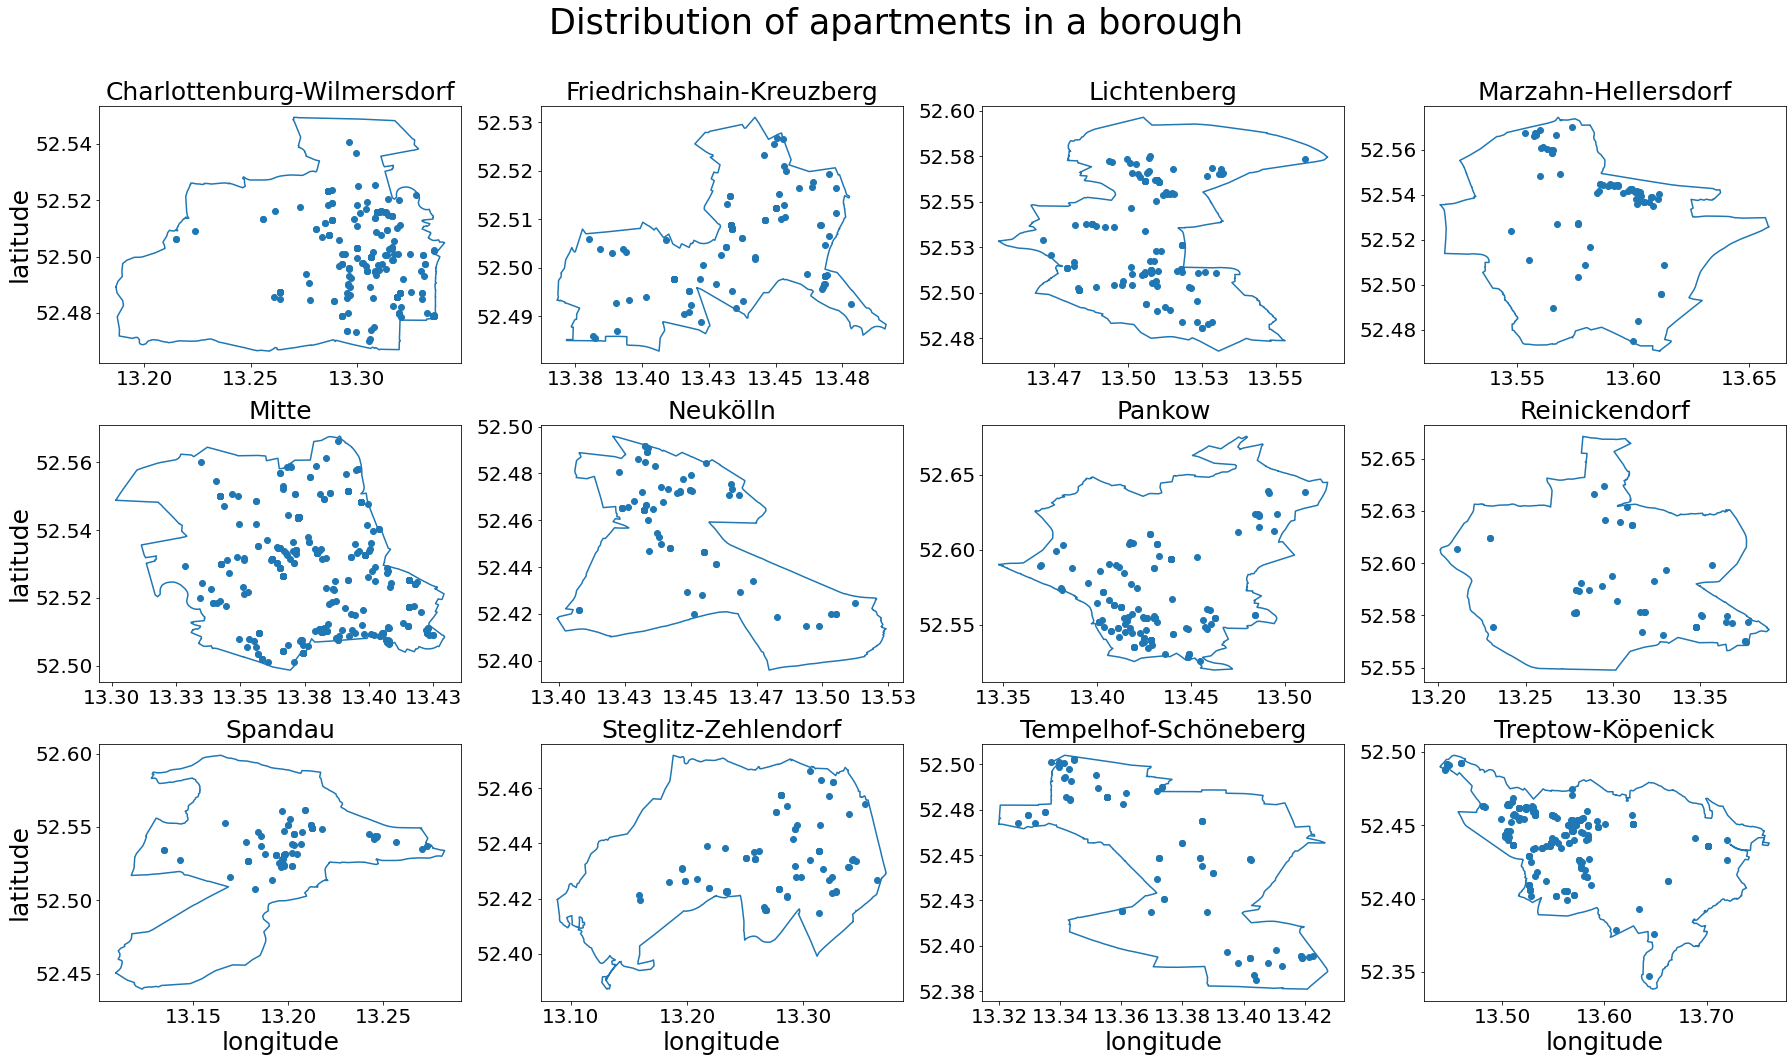

In [70]:
berlin = pd.read_json('Berlin.json', lines=True)
fig, axs = plt.subplots(3,4,figsize=(25,15),tight_layout=True)
fig.suptitle("Distribution of apartments in a borough\n",fontsize=35)

for i in range(3):
    for j in range(4):
        iteration = 4*i+j
        x=[]
        y=[]
        
        for element in berlin['geometry'][iteration]['coordinates'][0][0]:   
            x.append(element[0])
            y.append(element[1])
            
        axs[i,j].plot(x,y)
        axs[i,j].scatter(df[df['Borough']==berlin['properties'][iteration]['name']]['long'],df[df['Borough']==berlin['properties'][iteration]['name']]['lat'])
        axs[i,j].set_title(berlin['properties'][iteration]['name'] ,fontsize=25)
        axs[i,j].tick_params(axis='both',which='major',labelsize=20)
        axs[i,j].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axs[i,j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
        if i==2:
            axs[i,j].set_xlabel('longitude',fontsize=25)
        if j==0:
            axs[i,j].set_ylabel('latitude',fontsize=25)
fig.savefig('distribution_apartments.png')

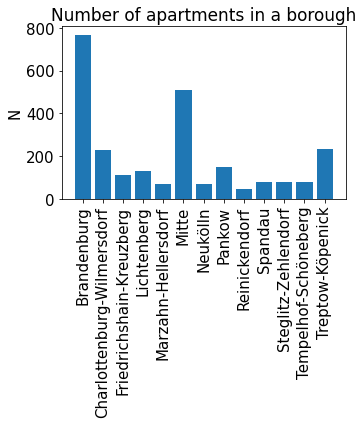

In [5]:
plt.figure(figsize=(5,6))
plt.bar(df.groupby('Borough').size().index,df.groupby('Borough').size())
plt.xticks(rotation = 90)
plt.ylabel('N',fontsize=15)
plt.title('Number of apartments in a borough',fontsize=17)
plt.tick_params(axis='both',which='major',labelsize=15)
plt.tight_layout()
plt.savefig('total_number.png')

### Foursquare informations

In [3]:
id_secr = open('id_secr.txt')
CLIENT_ID = id_secr.readline()
CLIENT_SECRET = id_secr.readline()
VERSION = '20180605'
LIMIT = 100 # limit of number of venues returned by Foursquare API
RADIUS = 500

In [4]:
def get_venues(i,latitude,longitude):
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    RADIUS, 
    LIMIT)

    results = requests.get(url).json()

    nearby_venues = pd.json_normalize(results['response']['groups'][0]['items'])

    if results['response']['totalResults']>0:
        venues_i = pd.DataFrame({'index':[i for j in range(len(nearby_venues))],
                               'name':nearby_venues['venue.name'],
                               'categorie':[nearby_venues['venue.categories'][j][0]['name'] for j in range(len(nearby_venues))],
                               'lat':nearby_venues['venue.location.lat'],
                               'long':nearby_venues['venue.location.lng']})
        return venues_i


### Get venues near by the apartments

In [7]:
for i in range(df.shape[0]):
    venues_i = get_venues(i,df.loc[i,'lat'],df.loc[i,'long'])
    if venues_i is not None:
        venues_i.to_csv('venues.csv', mode='a', header=False)

In [21]:
venues = pd.read_csv('venues.csv',names=['index','name','category','lat','long'])
venues.tail()

,index,name,category,lat,long
0,2553,"Maxes Baumdienst Max ""Klettermaxe"" Schäske",Tree,52.540916,13.917308
0,2554,EDEKA,Supermarket,52.095086,13.164714
1,2554,Bahnhof Luckenwalde,Train Station,52.090740,13.160965
2,2554,Steffen Huschke - Sanitär- und Heizungsbau,Construction & Landscaping,52.091012,13.157817
3,2554,NETTO,Supermarket,52.096137,13.165271


In [22]:
venue_borough = []
for i in venues['index']:
    venue_borough.append(df.loc[i,'Borough'])
venues.insert(0,'Borough',venue_borough,True)
venues.head()

,Borough,index,name,category,lat,long
0,Friedrichshain-Kreuzberg,0,Trattoria La Bruschetta,Trattoria/Osteria,52.513219,13.431330
1,Friedrichshain-Kreuzberg,0,MOXY Berlin Ostbahnhof,Hotel,52.511046,13.430107
2,Friedrichshain-Kreuzberg,0,Novum Select Hotel Berlin Ostbahnhof,Hotel,52.512036,13.432016
3,Friedrichshain-Kreuzberg,0,Viet Ha - Goldener Karpfen,Asian Restaurant,52.519261,13.433383
4,Friedrichshain-Kreuzberg,0,ehem. Karl-Marx-Buchhandlung,Historic Site,52.517284,13.438109


In [23]:
#one hot encoding
venues_onehot = pd.get_dummies(venues[['category']], prefix="", prefix_sep="")

venues_onehot.insert(0,'Borough',venues['Borough'],True)
venues_onehot.insert(1,'Index',venues['index'],True)
venues_onehot.head()

,Borough,Index,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo Exhibit
0,Friedrichshain-Kreuzberg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Friedrichshain-Kreuzberg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Friedrichshain-Kreuzberg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Friedrichshain-Kreuzberg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Friedrichshain-Kreuzberg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
venues_onehot.shape

(57098, 437)

In [25]:
venues_grouped = venues_onehot.groupby('Borough').mean().reset_index()
venues_grouped.drop('Index',axis=1,inplace=True)
venues_grouped

,Borough,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo Exhibit
0,Brandenburg,0.000957,0.000000,0.000000,0.000000,0.000718,0.000239,0.000000,0.000239,0.002631,...,0.000000,0.000000,0.000000,0.003348,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Charlottenburg-Wilmersdorf,0.000902,0.000000,0.000644,0.000515,0.002577,0.000258,0.000258,0.000000,0.000644,...,0.000000,0.000515,0.000773,0.001031,0.004510,0.002319,0.000515,0.000000,0.000258,0.000258
2,Friedrichshain-Kreuzberg,0.000000,0.000384,0.000000,0.006728,0.000769,0.000000,0.000000,0.000000,0.000384,...,0.000384,0.007305,0.000192,0.006344,0.008074,0.000000,0.000384,0.000000,0.006728,0.000577
3,Lichtenberg,0.000000,0.001349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002023,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003372
4,Marzahn-Hellersdorf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Mitte,0.000338,0.000038,0.000000,0.000113,0.000150,0.000000,0.000000,0.000000,0.000075,...,0.000000,0.004434,0.000413,0.003608,0.000338,0.000000,0.000038,0.000113,0.002818,0.000150
6,Neukölln,0.000000,0.000000,0.000000,0.004332,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001856,0.000619,0.003094,0.009282,0.000000,0.000000,0.002475,0.003094,0.000000
7,Pankow,0.000000,0.000567,0.000000,0.000000,0.001702,0.000000,0.000000,0.000000,0.000851,...,0.000000,0.000000,0.000000,0.009643,0.002552,0.000000,0.000000,0.000000,0.000851,0.000000
8,Reinickendorf,0.000000,0.006881,0.000000,0.000000,0.002294,0.000000,0.000000,0.000000,0.004587,...,0.000000,0.006881,0.000000,0.000000,0.002294,0.000000,0.000000,0.000000,0.000000,0.000000
9,Spandau,0.010010,0.002002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006006,...,0.000000,0.000000,0.000000,0.001001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
most_common_venues = []
columns = []
for i in range(10):columns.append(str(i+1)+'. most frequent venue')

for Borough in venues_grouped['Borough'].values:
    part = venues_grouped[venues_grouped['Borough']==Borough].T.reset_index()
    part.columns = ['venue','freq']
    part = part.iloc[1:]
    part = part.sort_values(by='freq',ascending=False).reset_index(drop=True)
    most_common_venues.append(part.loc[:9,'venue'].values)

venues_grouped_freq = pd.concat([pd.DataFrame([most_common_venues[i]],columns=columns) for i in range(13)],ignore_index=True)
venues_grouped_freq.set_index(venues_grouped['Borough'].values,inplace=True)
venues_grouped_freq

,1. most frequent venue,2. most frequent venue,3. most frequent venue,4. most frequent venue,5. most frequent venue,6. most frequent venue,7. most frequent venue,8. most frequent venue,9. most frequent venue,10. most frequent venue
Brandenburg,Hotel,German Restaurant,Supermarket,Café,Vacation Rental,Bakery,Italian Restaurant,Clothing Store,Drugstore,French Restaurant
Charlottenburg-Wilmersdorf,Hotel,Italian Restaurant,Supermarket,Café,Bakery,German Restaurant,Vietnamese Restaurant,Plaza,Chinese Restaurant,Trattoria/Osteria
Friedrichshain-Kreuzberg,Café,Bar,Coffee Shop,Italian Restaurant,Bakery,Nightclub,Hotel,Supermarket,Vegetarian / Vegan Restaurant,Pizza Place
Lichtenberg,Supermarket,Tram Station,Drugstore,Bakery,Café,Bus Stop,Park,Fast Food Restaurant,Shopping Mall,Hotel
Marzahn-Hellersdorf,Supermarket,Tram Station,Bus Stop,Bank,Bakery,Gym / Fitness Center,Multiplex,Shopping Mall,Climbing Gym,Drugstore
Mitte,Hotel,Coffee Shop,Café,Bakery,Italian Restaurant,Hotel Bar,Supermarket,Restaurant,Bar,Gym / Fitness Center
Neukölln,Bar,Café,Coffee Shop,Supermarket,Bakery,Bus Stop,Italian Restaurant,Breakfast Spot,Plaza,Turkish Restaurant
Pankow,Café,Supermarket,Bakery,Tram Station,Italian Restaurant,Coffee Shop,Vietnamese Restaurant,Organic Grocery,Park,Bar
Reinickendorf,Supermarket,Bakery,Restaurant,Café,Bus Stop,Italian Restaurant,German Restaurant,Indian Restaurant,Ice Cream Shop,Clothing Store
Spandau,Supermarket,Bus Stop,Pizza Place,Drugstore,Clothing Store,Italian Restaurant,Ice Cream Shop,Fast Food Restaurant,Hotel,Bakery


### Clustering

#### 2 Clusters

In [70]:
venue_cluster = venues_grouped.drop('Borough', axis=1)

kmeans = KMeans(n_clusters=2, random_state=0).fit(venue_cluster)
kmeans.labels_

df_cluster = pd.DataFrame({'Borough':pd.unique(venues_grouped['Borough']),'Cluster':kmeans.labels_})
df_cluster

,Borough,Cluster
0,Brandenburg,0
1,Charlottenburg-Wilmersdorf,0
2,Friedrichshain-Kreuzberg,0
3,Lichtenberg,1
4,Marzahn-Hellersdorf,1
5,Mitte,0
6,Neukölln,0
7,Pankow,0
8,Reinickendorf,1
9,Spandau,1


In [71]:
locator = Nominatim(user_agent="myGeocoder")
berlin_loc = locator.geocode('Berlin, Deutschland')
map_berlin = folium.Map(location=[berlin_loc[1][0], berlin_loc[1][1]], zoom_start=10)

colors = ['red','purple']

for i in range(12):
    coordinates = []
    for element in berlin['geometry'][i]['coordinates'][0][0]:   
        coordinates.append((element[1],element[0]))
        
    folium.PolyLine(coordinates,color="blue",weight=2).add_to(map_berlin)
    
    X=berlin['geometry'][i]['coordinates'][0][0]
    k_means = KMeans(init = "k-means++", n_clusters = 1, n_init = 12)
    k_means.fit(X)
    k_means_cluster_centers = k_means.cluster_centers_
    
    folium.CircleMarker(
            [k_means_cluster_centers[0][1], k_means_cluster_centers[0][0]],
            radius=5,
            popup=berlin['properties'][i]['name'],
            color=colors[df_cluster[df_cluster['Borough']==berlin['properties'][i]['name']]['Cluster'].values[0]],
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_berlin)

map_berlin

#### 3 Clusters

In [72]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(venue_cluster)
kmeans.labels_

df_cluster = pd.DataFrame({'Borough':pd.unique(venues_grouped['Borough']),'Cluster':kmeans.labels_})
df_cluster

,Borough,Cluster
0,Brandenburg,2
1,Charlottenburg-Wilmersdorf,2
2,Friedrichshain-Kreuzberg,2
3,Lichtenberg,0
4,Marzahn-Hellersdorf,1
5,Mitte,2
6,Neukölln,2
7,Pankow,0
8,Reinickendorf,0
9,Spandau,0


In [73]:
map_berlin = folium.Map(location=[berlin_loc[1][0], berlin_loc[1][1]], zoom_start=10)

colors = ['red','purple','yellow']

for i in range(12):
    coordinates = []
    for element in berlin['geometry'][i]['coordinates'][0][0]:   
        coordinates.append((element[1],element[0]))
        
    folium.PolyLine(coordinates,color="blue",weight=2).add_to(map_berlin)
    
    X=berlin['geometry'][i]['coordinates'][0][0]
    k_means = KMeans(init = "k-means++", n_clusters = 1, n_init = 12)
    k_means.fit(X)
    k_means_cluster_centers = k_means.cluster_centers_
    
    folium.CircleMarker(
            [k_means_cluster_centers[0][1], k_means_cluster_centers[0][0]],
            radius=5,
            popup=berlin['properties'][i]['name'],
            color=colors[df_cluster[df_cluster['Borough']==berlin['properties'][i]['name']]['Cluster'].values[0]],
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_berlin)

map_berlin

#### 4 Clusters

In [74]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(venue_cluster)
kmeans.labels_

df_cluster = pd.DataFrame({'Borough':pd.unique(venues_grouped['Borough']),'Cluster':kmeans.labels_})
df_cluster

,Borough,Cluster
0,Brandenburg,3
1,Charlottenburg-Wilmersdorf,0
2,Friedrichshain-Kreuzberg,0
3,Lichtenberg,1
4,Marzahn-Hellersdorf,2
5,Mitte,0
6,Neukölln,0
7,Pankow,0
8,Reinickendorf,1
9,Spandau,1


In [75]:
map_berlin = folium.Map(location=[berlin_loc[1][0], berlin_loc[1][1]], zoom_start=10)

colors = ['red','purple','yellow','orange']

for i in range(12):
    coordinates = []
    for element in berlin['geometry'][i]['coordinates'][0][0]:   
        coordinates.append((element[1],element[0]))
        
    folium.PolyLine(coordinates,color="blue",weight=2).add_to(map_berlin)
    
    X=berlin['geometry'][i]['coordinates'][0][0]
    k_means = KMeans(init = "k-means++", n_clusters = 1, n_init = 12)
    k_means.fit(X)
    k_means_cluster_centers = k_means.cluster_centers_
    
    folium.CircleMarker(
            [k_means_cluster_centers[0][1], k_means_cluster_centers[0][0]],
            radius=5,
            popup=berlin['properties'][i]['name'],
            color=colors[df_cluster[df_cluster['Borough']==berlin['properties'][i]['name']]['Cluster'].values[0]],
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_berlin)

map_berlin

#### 5 Clusters

In [76]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(venue_cluster)
kmeans.labels_

df_cluster = pd.DataFrame({'Borough':pd.unique(venues_grouped['Borough']),'Cluster':kmeans.labels_})
df_cluster

,Borough,Cluster
0,Brandenburg,3
1,Charlottenburg-Wilmersdorf,0
2,Friedrichshain-Kreuzberg,0
3,Lichtenberg,1
4,Marzahn-Hellersdorf,2
5,Mitte,0
6,Neukölln,0
7,Pankow,1
8,Reinickendorf,4
9,Spandau,4


In [77]:
map_berlin = folium.Map(location=[berlin_loc[1][0], berlin_loc[1][1]], zoom_start=10)

colors = ['red','purple','yellow','orange','blue']

for i in range(12):
    coordinates = []
    for element in berlin['geometry'][i]['coordinates'][0][0]:   
        coordinates.append((element[1],element[0]))
        
    folium.PolyLine(coordinates,color="blue",weight=2).add_to(map_berlin)
    
    X=berlin['geometry'][i]['coordinates'][0][0]
    k_means = KMeans(init = "k-means++", n_clusters = 1, n_init = 12)
    k_means.fit(X)
    k_means_cluster_centers = k_means.cluster_centers_
    
    folium.CircleMarker(
            [k_means_cluster_centers[0][1], k_means_cluster_centers[0][0]],
            radius=5,
            popup=berlin['properties'][i]['name'],
            color=colors[df_cluster[df_cluster['Borough']==berlin['properties'][i]['name']]['Cluster'].values[0]],
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_berlin)

map_berlin